# Ulcerative Colitis: data analysis for XAUT1-Blood

Author: Yang-Joon Kim

last updated: 11/22/2022

The raw data was processed in R/Seurat by Chris Anderson, including the low Q cell filtering(?), clustering (louvain), batch correction, and annotation.
The annotation of cell types is curated by Mike Kattah and his group members.

This notebook is for the downstream analyses such as DE, and generation of plots that Chris generated as well as some new analyses/plots.

- batch correction was done using Harmony in Seurat

- Top DE genes that were computed by Wilcoxon rank sum test (or t-test) were not that specific, and could be due to 1) noisy annotation, 2) quality of the data.
- We will manually check the marker genes by taking out non-specific markers and put some known markers (such as Jchain for plasma cells)

- There were two issues from the V4 notebook: 
    1) the exported anndata from the original Seurat object had "scaled" counts, not the "raw counts" (not even just log-normalized, it was scaled in a weird way.
    2) from Michael's annotation, he somehow got rid of 4K genes during the annotation. Our original object had the correct number of genes (22K), but the final object had only 18K genes.
    
Here, we try to fix these issues, which will likely make some changes to the dot plots, and downstream plots except UMAP, PCA, that are already computed.

## Load the datasets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import os
import scvi
import sys 

sys.path.append('/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/')
import utils

Global seed set to 0


In [2]:
# make folder for processed adata object and figures
data_directory = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/annotated_data/'

figure_directory = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/figures/XAUT1-Blood/'

sc.settings.figdir = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/Manuscript/Figures/XAUT1/'

if not os.path.exists(data_directory):
    os.makedirs(data_directory)
if not os.path.exists(figure_directory):
    os.makedirs(figure_directory)    

#print package versions
print('package versions:')
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

# # make sure you use these two parameters before saving figures to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=200)

package versions:
numpy 1.21.0
pandas 1.4.2
seaborn 0.11.2
scanpy 1.8.2
scvi 0.16.1


In [3]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import ks_2samp
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import tifffile
import fs
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [5]:
# Read the adata object
adata = sc.read_h5ad('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG11_14_Blood/Cellxgene/Blood_MK_version/22_6_13_blood_RNA_V6.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 20130 × 22741
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'CoLabs_ID', 'CoLabs_patient', 'condition', 'MK final coarse_V2', 'MK final fine annotations_V2', 'MK final coarse_V2 a4B7', 'MK final fine annotations_V2 a4B7'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'dendrogram_MK final coarse_V2', 'neighbors', 'rank_genes_groups'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'counts'
    obsp: 'distances'

In [8]:
# check if the adata.X is log-normalized
np.sum(np.expm1(adata.X.todense()),1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

## generate the dot plots and UMAPs

In [9]:
# First, let's subset the anndata for fine cell-type groups
adata_B = adata[adata.obs["MK final fine annotations_V2"].isin(
    ['01A_B_naive','01B_B_memory'])]
adata_CD4 = adata[adata.obs["MK final fine annotations_V2"].isin(
    ['03B_CD4 TEM and CTL',
     '03C_CD4_NAIVE', 
     '03D_dnT'])]
adata_CD8 = adata[adata.obs["MK final fine annotations_V2"].isin(
    ['06A_CD8 TEM',
 '06B_CD8 TCM',
 '06C_CD8_NAIVE'])]

In [10]:
# Run Wilcoxon rank sum test for all these subsetted anndata (as well as the full anndata)
sc.tl.rank_genes_groups(adata, groupby='MK final coarse_V2', method='wilcoxon')
sc.tl.rank_genes_groups(adata_B, groupby='MK final fine annotations_V2', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CD4, groupby='MK final fine annotations_V2', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CD8, groupby='MK final fine annotations_V2', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:06)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


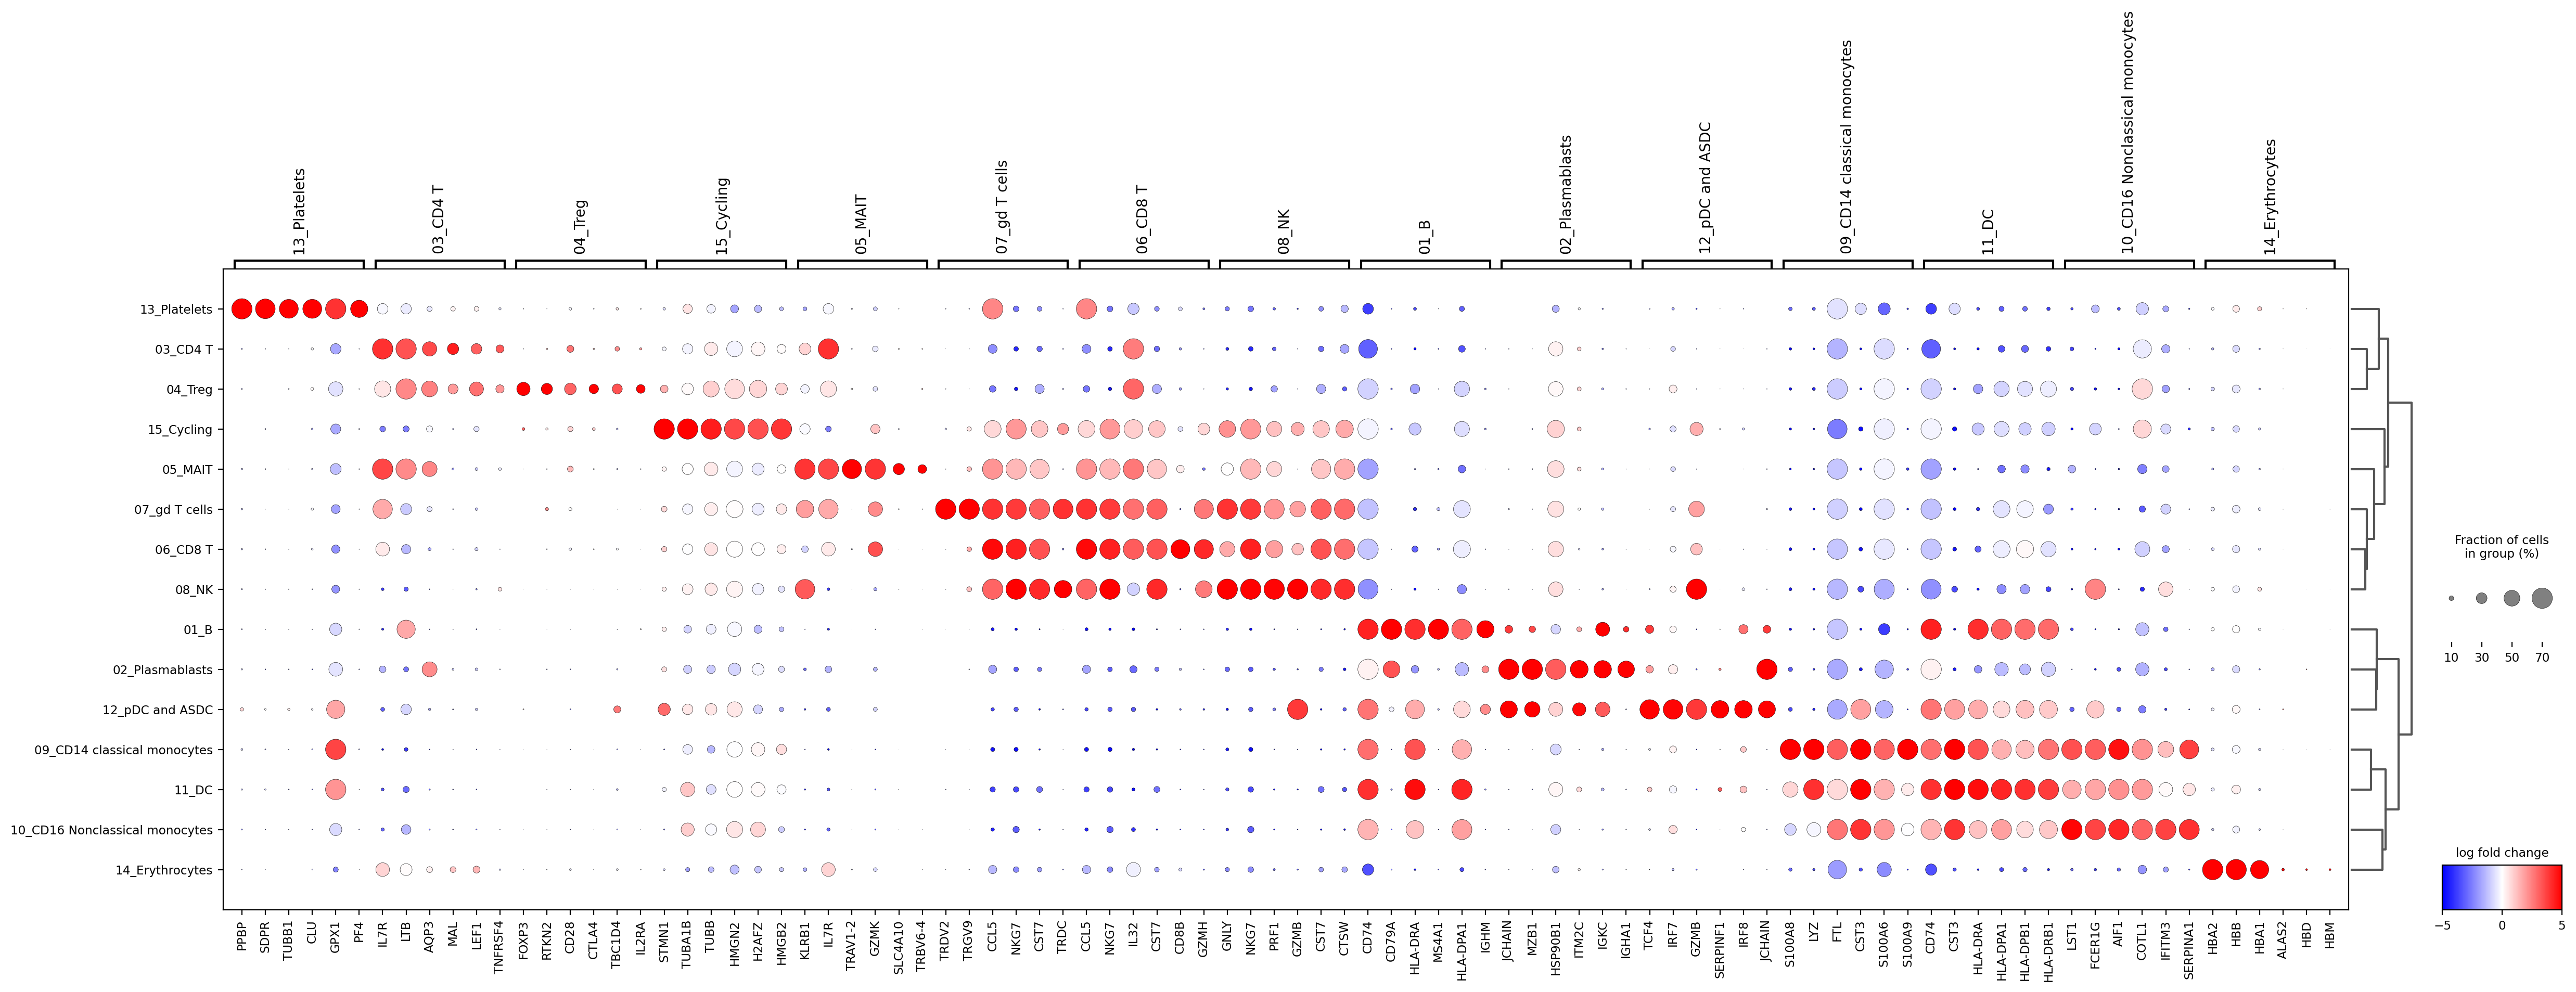

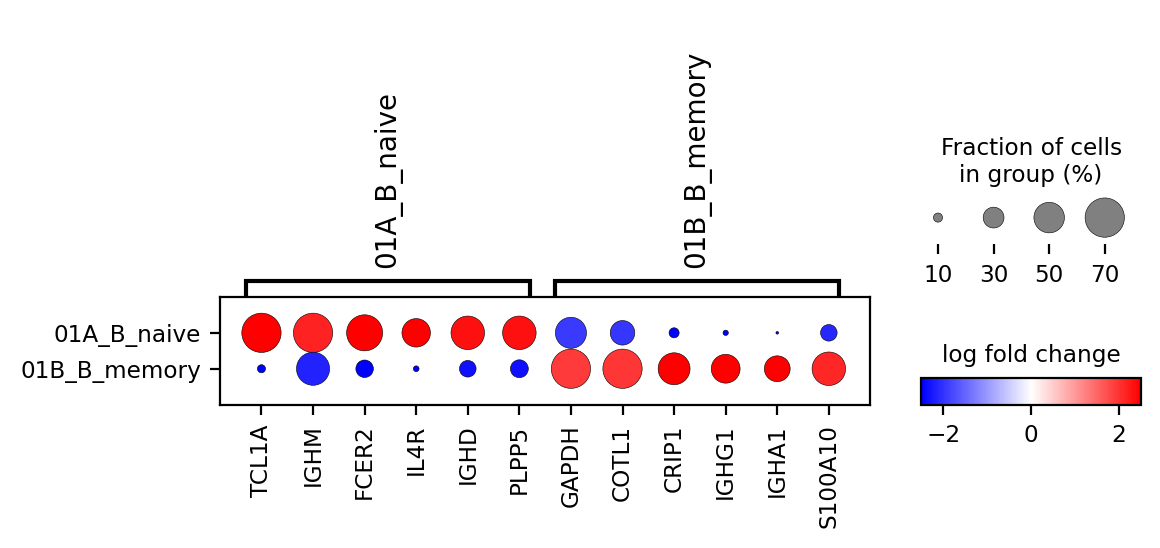

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_MK final fine annotations_V2']`


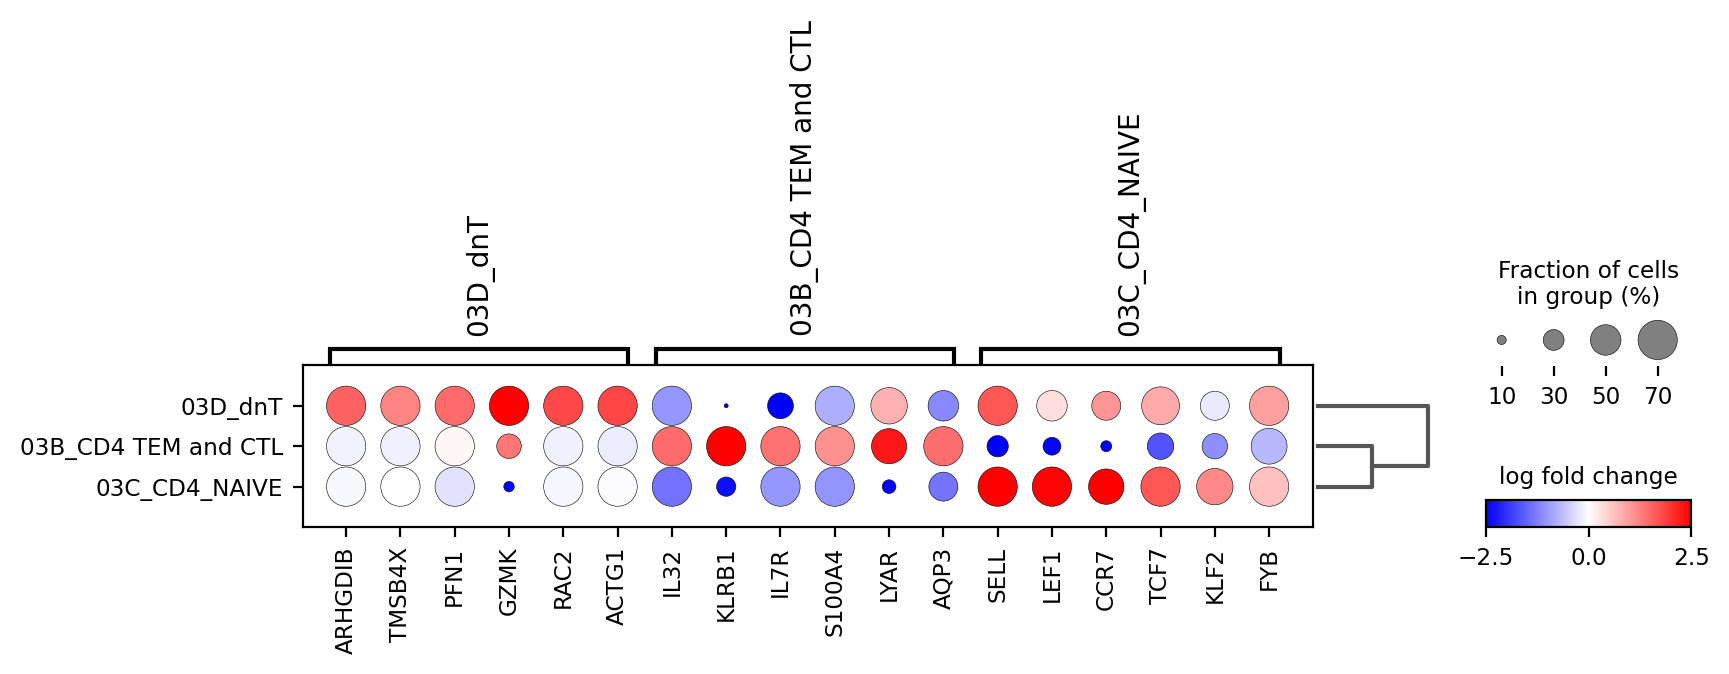

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_MK final fine annotations_V2']`


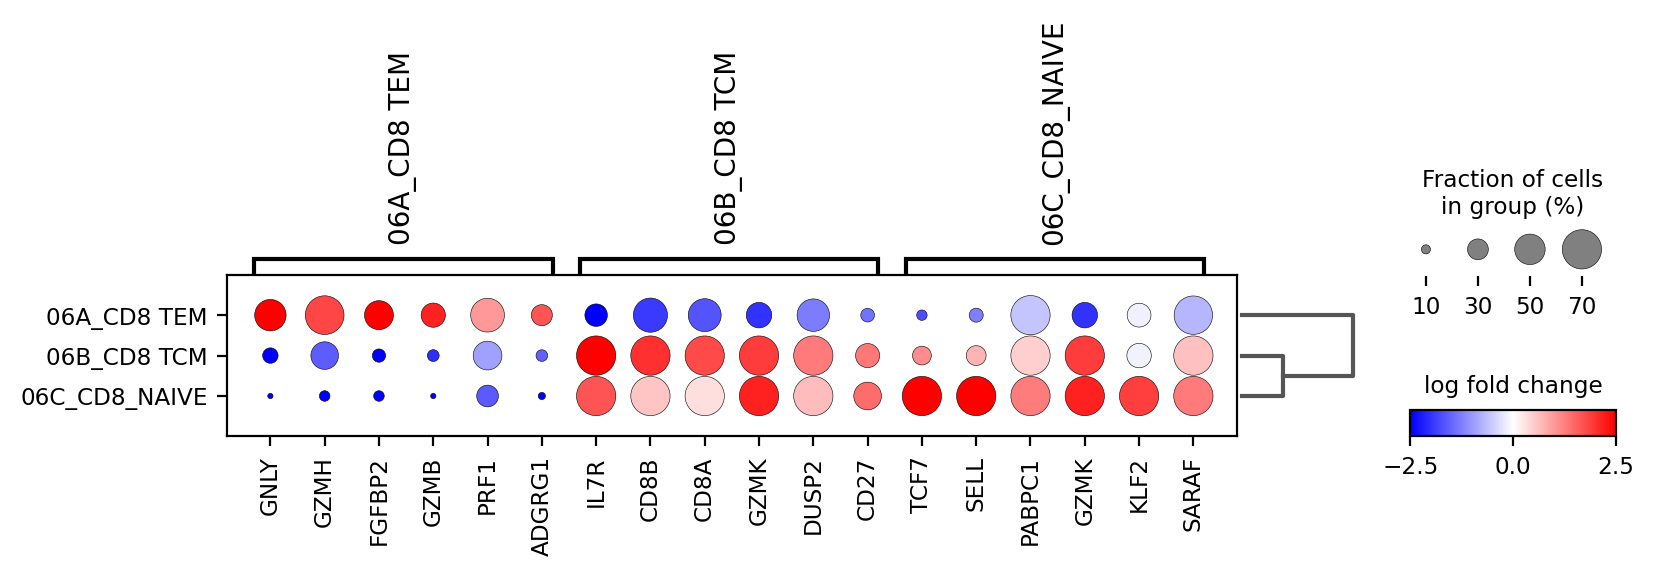

In [11]:
# Generating the dot plots for top 6 genes from Wilcoxon rank sum test
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=5, vmin=-5, cmap='bwr', figsize=(29,8), dot_max=0.7, save="22_06_15_blood_all_coarse.pdf")
sc.pl.rank_genes_groups_dotplot(adata_B, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=1.75, vmax=2.5, vmin=-2.5,dot_max=0.7, cmap='bwr', save="22_06_15_blood_B_fine.pdf")
sc.pl.rank_genes_groups_dotplot(adata_CD4, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=0.5, vmax=2.5, vmin=-2.5,dot_max=0.7, cmap='bwr', save="22_06_15_blood_CD4_fine.pdf")
sc.pl.rank_genes_groups_dotplot(adata_CD8, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=1, vmax=2.5, vmin=-2.5,dot_max=0.7, cmap='bwr', save="22_06_15_blood_CD8_fine.pdf")

## UMAP visualization

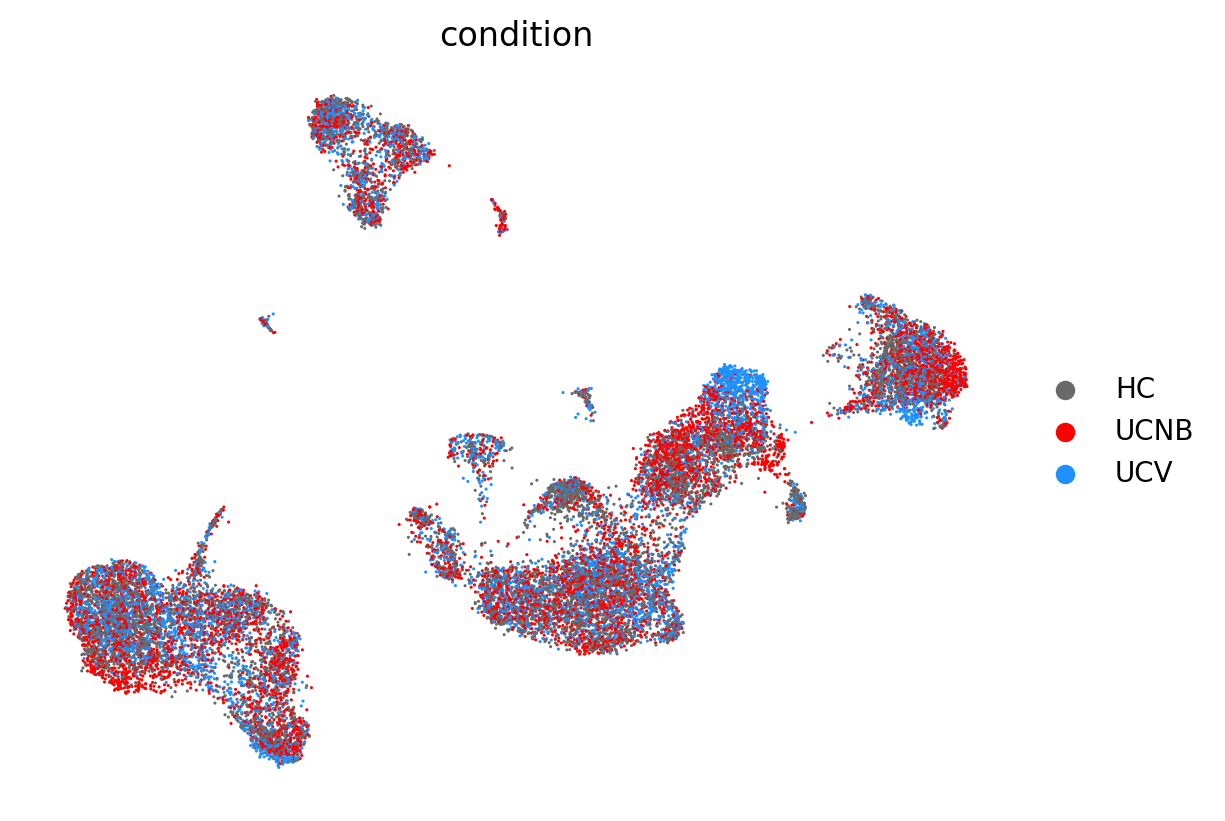

In [12]:
# UMAP visualization
# Subsetting to a smaller number of categories:

adata = adata[adata.obs["condition"].isin(["HC", "UCNB", "UCV"])].copy()
# with rc_context({'figure.figsize': (4, 4)})
sc.pl.umap(adata, color="condition", s=5, frameon=False, ncols=4, vmax='p99',
    palette={
        "HC": "dimgrey",
        "UCNB": "red",
        "UCV": "dodgerblue",},
    save="_22_5_15_blood_condition.pdf")

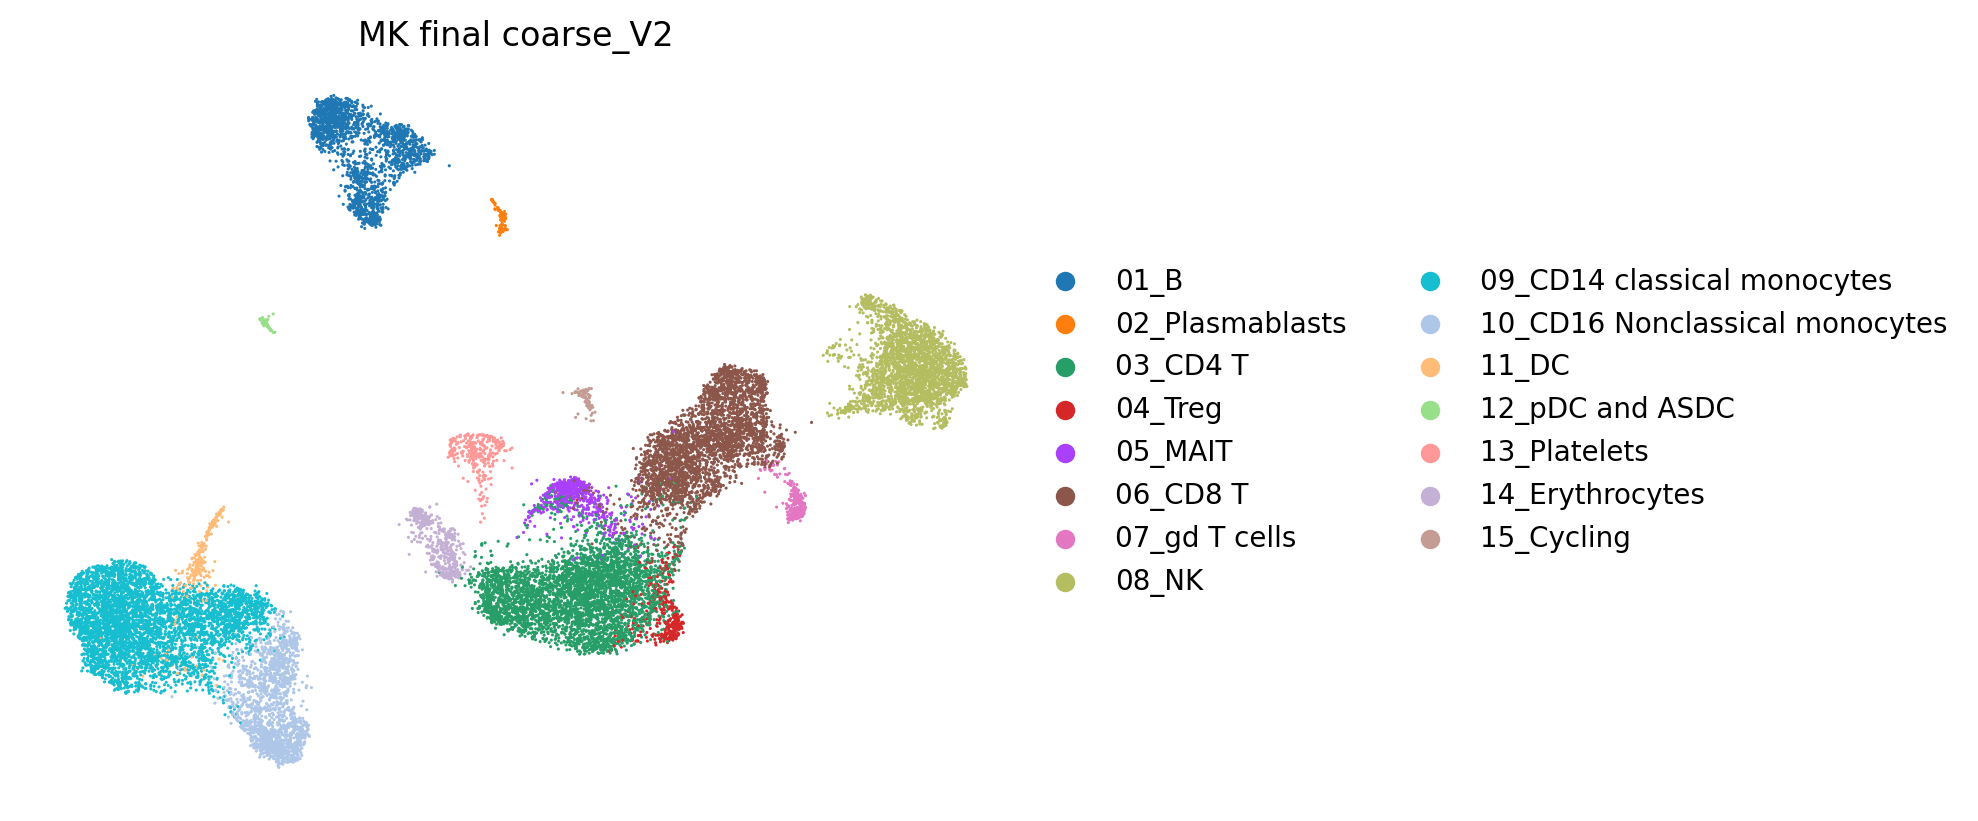

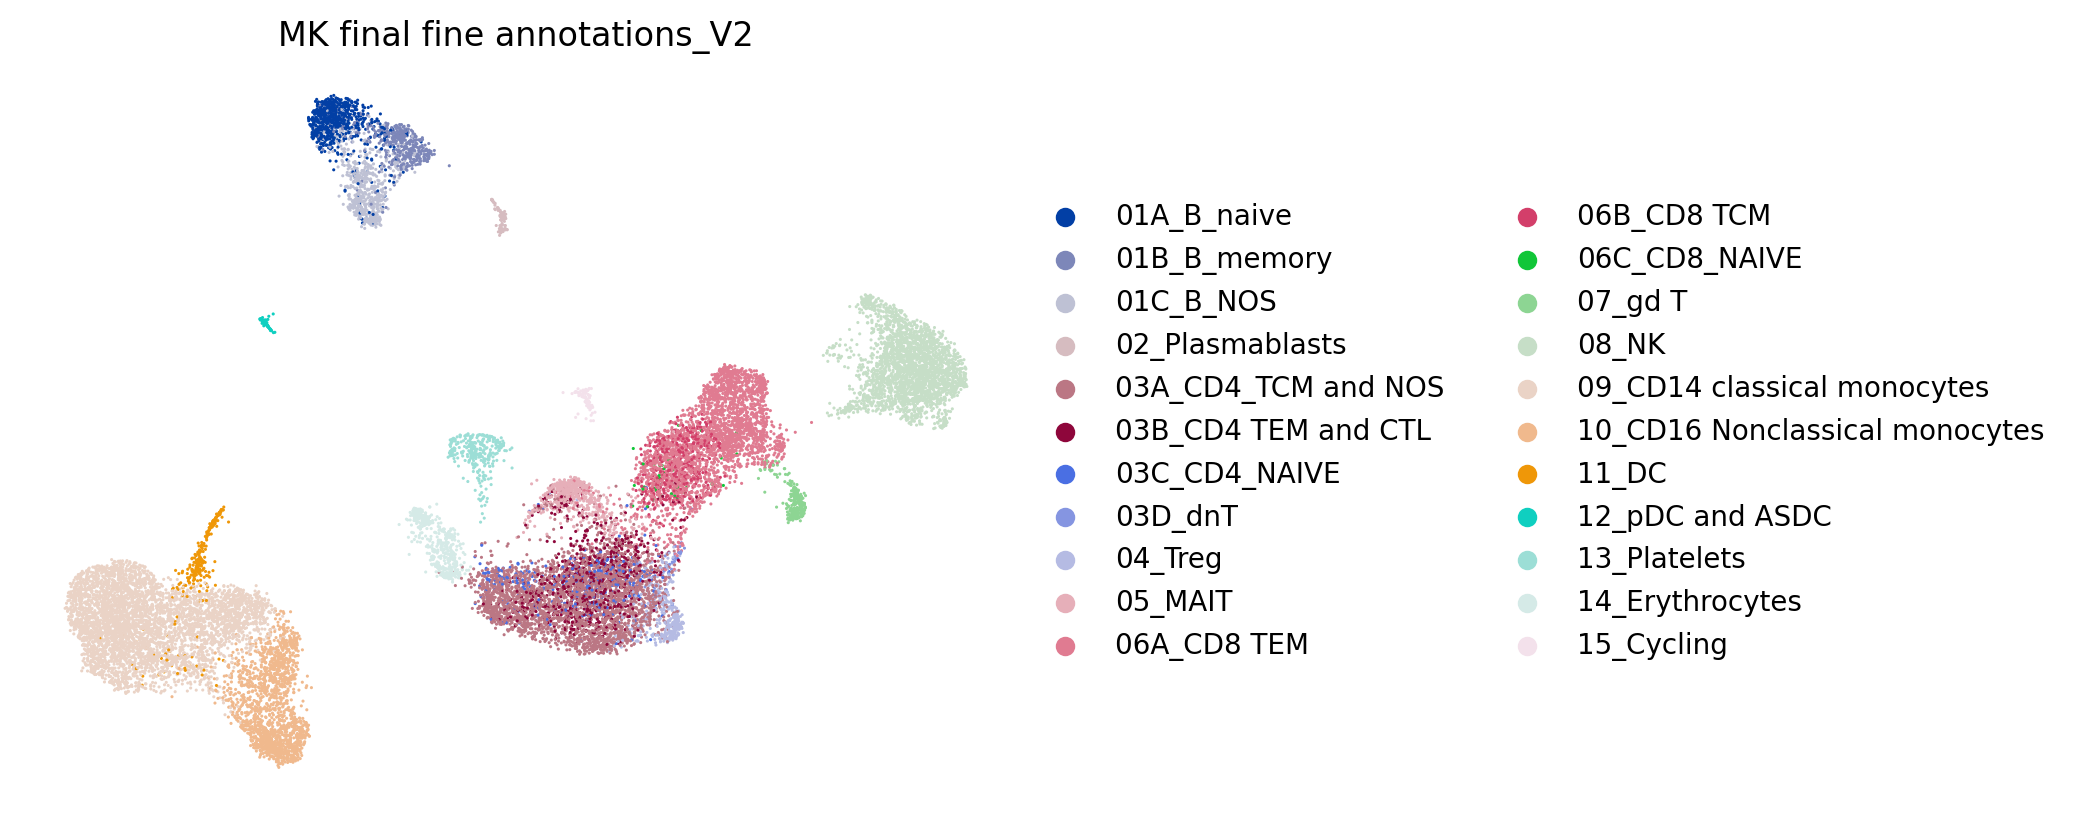

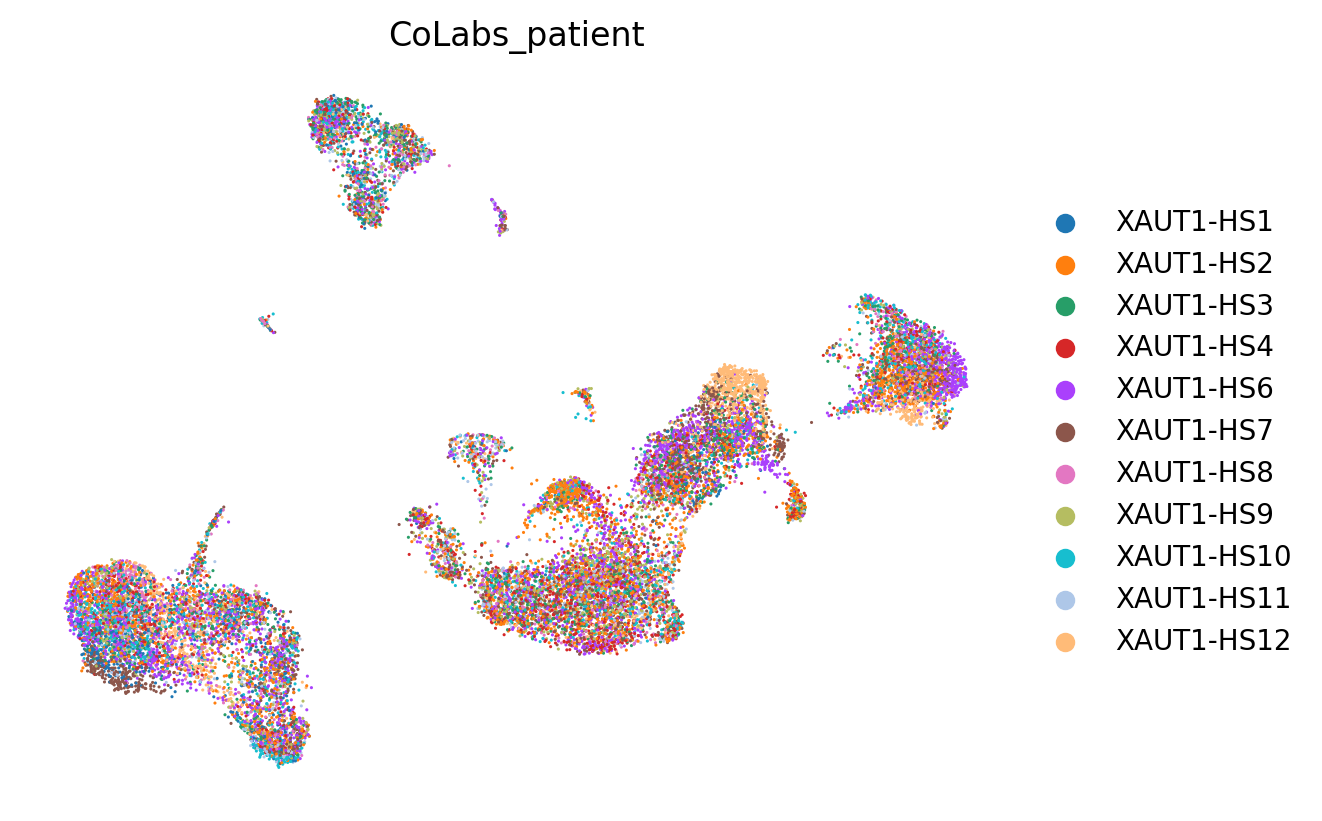

In [15]:
# different UMAP visualizations (different groups)
sc.pl.umap(adata, color=['MK final coarse_V2'],s=5, frameon=False, ncols=4, vmax='p99', save="_22_5_15_blood_coarse.pdf")
#sc.pl.umap(adata, color=['louvain_res1'],s=5, frameon=False, ncols=4, vmax='p99', save="_22_5_15_blood_louvain1.pdf")
sc.pl.umap(adata, color=['MK final fine annotations_V2'],s=5, frameon=False, ncols=4, vmax='p99', save="_22_5_15_blood_fine.pdf")
sc.pl.umap(adata, color=['CoLabs_patient'],s=5, frameon=False, ncols=4, vmax='p99', save="_22_5_15_blood_patient.pdf")


## Cell type abundances table (dataframe)

In [154]:
list_cell_types = adata.obs["louvain_res1"].unique().to_list()
list_cell_types.sort()
list_cell_types

['00-NK',
 '01-CD8 Tcm MAIT gd T',
 '02-CD14 classical monocytes',
 '03-CD4_1',
 '04-CD4_2',
 '05-CD8 Tem and gd T',
 '06-DC_2',
 '07-Treg and dnT',
 '08-B naive and memory',
 '09-CD16 Nonclassical monocytes_1',
 '10-Monocyte NOS',
 '11-Nonclassical monocytes_2',
 '12-B NOS',
 '13-Platelets',
 '14-pDC ans ASDC and plasmablasts',
 '15-Erythrocytes',
 '16-DC_1',
 '17-Cycling']

In [155]:
list_patient_IDs = adata.obs["CoLabs_patient"].unique().to_list()
list_patient_IDs.sort()
list_patient_IDs

['XAUT1-HS1',
 'XAUT1-HS10',
 'XAUT1-HS11',
 'XAUT1-HS12',
 'XAUT1-HS2',
 'XAUT1-HS3',
 'XAUT1-HS4',
 'XAUT1-HS6',
 'XAUT1-HS7',
 'XAUT1-HS8',
 'XAUT1-HS9']

In [156]:
# initialize the dataframe
cell_type_abundances = pd.DataFrame(np.zeros((len(list_patient_IDs), len(list_cell_types))),dtype = np.int16,
                                    index = list_patient_IDs,
                                    columns = list_cell_types)

cell_type_abundances

,00-NK,01-CD8 Tcm MAIT gd T,02-CD14 classical monocytes,03-CD4_1,04-CD4_2,05-CD8 Tem and gd T,06-DC_2,07-Treg and dnT,08-B naive and memory,09-CD16 Nonclassical monocytes_1,10-Monocyte NOS,11-Nonclassical monocytes_2,12-B NOS,13-Platelets,14-pDC ans ASDC and plasmablasts,15-Erythrocytes,16-DC_1,17-Cycling
XAUT1-HS1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XAUT1-HS8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
# calculate the number of cells in each cell-type for each patient, then fill in the dataframe
for i in range(0,len(list_patient_IDs)):
    for j in range(0,len(list_cell_types)):
        patient_ID = list_patient_IDs[i]
        cell_type = list_cell_types[j]
        
        num_cells = len(adata[(adata.obs["CoLabs_patient"]==patient_ID) & (adata.obs["louvain_res1"]==cell_type)])
        
        cell_type_abundances.loc[patient_ID,cell_type] = num_cells
        
cell_type_abundances

,00-NK,01-CD8 Tcm MAIT gd T,02-CD14 classical monocytes,03-CD4_1,04-CD4_2,05-CD8 Tem and gd T,06-DC_2,07-Treg and dnT,08-B naive and memory,09-CD16 Nonclassical monocytes_1,10-Monocyte NOS,11-Nonclassical monocytes_2,12-B NOS,13-Platelets,14-pDC ans ASDC and plasmablasts,15-Erythrocytes,16-DC_1,17-Cycling
XAUT1-HS1,7,82,227,17,19,18,135,17,106,75,68,43,49,13,6,8,9,0
XAUT1-HS10,238,85,277,117,121,53,109,117,160,110,77,92,61,20,12,2,8,10
XAUT1-HS11,73,61,88,114,139,18,69,71,91,53,35,31,52,72,21,4,7,4
XAUT1-HS12,210,158,117,51,67,484,177,85,24,43,63,21,13,27,5,9,4,7
XAUT1-HS2,491,471,349,349,322,186,151,219,74,164,100,91,41,46,11,20,13,22
XAUT1-HS3,174,248,132,155,183,121,99,104,176,66,76,33,75,22,11,13,8,3
XAUT1-HS4,167,238,200,259,209,88,120,143,104,45,69,19,47,21,6,13,9,4
XAUT1-HS6,636,502,379,301,240,233,263,162,129,184,162,107,57,38,41,15,13,12
XAUT1-HS7,310,317,191,205,264,239,109,137,118,147,71,85,69,32,21,22,11,8
XAUT1-HS8,138,85,173,84,101,10,122,66,91,54,53,37,51,17,18,3,7,1


In [159]:
cell_type_abundances.to_csv('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG11_14_Blood/Cellxgene/Blood MK version/XAUT1_Blood_abundances.csv')